# Nearest Neighbour Query

In [1]:
# Import necessary modules
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points
import geopandas as gpd

## Nearest point using shapely

In [2]:
# Define a point and a cluster
orig = Point(1, 1.67)
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)
destinations = MultiPoint([dest1, dest2, dest3])

In [3]:
# Find the nearest point
nearest_geoms = nearest_points(orig, destinations)
print(nearest_geoms)
print(nearest_geoms[0], nearest_geoms[1])
# Tuple returned contains origin & nearest point

(<shapely.geometry.point.Point object at 0x7f025377e2e8>, <shapely.geometry.point.Point object at 0x7f025377e400>)
POINT (1 1.67) POINT (0 1.45)


## Nearest point using GeoPandas

In [4]:
# Enable the KML-driver by passing 'rw' to whitelist of fiona’s supported drivers:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [5]:
# Read in addresses from previous tutorial
addresses = gpd.read_file("Data/addresses.shp")

# Read in the KML file
districts = gpd.read_file("Data/PKS_suuralue.kml", driver='KML')
addresses.head()

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.9155624 60.1632015)
1,"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.9316914 60.1690222)
2,"Citycenter, 8, Kaivokatu, Keskusta, Kluuvi, Et...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (24.94244049213 60.16988445)
3,"1, Hermannin rantatie, Hermanninmäki, Hermanni...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (24.9654618 60.2009041)
4,"Hesburger Jätkäsaari, 9, Tyynenmerenkatu, Jätk...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland",POINT (24.9216003 60.1566475)


In [6]:
# Calculate the centroid of each district
districts['centroid'] = districts.centroid
districts.head()

,Name,Description,geometry,centroid
0,Suur-Espoonlahti,,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116)
1,Suur-Kauklahti,,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445)
2,Vanha-Espoo,,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344)
3,Pohjois-Espoo,,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335)
4,Suur-Matinkylä,,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097)


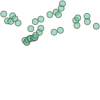

In [7]:
# Create unary union from Points, which basically creates a MultiPoint object from the Point geometries.
addressUnion = addresses.unary_union
addressUnion

In [8]:
# Test the 'nearest_points' functionality. The function returns the nearest points from two DataFrames
# Here we use the result to create a mask by desting for equality in the addresses['geometry'] column.
addresses['geometry'] == nearest_points(districts.loc[2]["centroid"], addressUnion)[1]


0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16     True
17    False
18    False
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
Name: geometry, dtype: bool

In [9]:
# Now we define a function that can be applied to each row of the districts DataFrame,
# and that returns values selected from a selected column of the addresses DataFrame
# Need to pass in both the addressUnion collection and the addresses dataFrame

def nearest(row, addresses, addressUnion, districts, srcColName='id'):
    """Find the nearest point and return the corresponding value from specified column."""
    
    # Find the centroid in the row of district that is closest
    # Create a mask to select the addresses DataFrame
    nearMsk = addresses['geometry'] == nearest_points(row["centroid"], addressUnion)[1]
    
    # Get the corresponding value from the addresses DataFrame
    value = addresses[nearMsk][srcColName].get_values()[0]
    
    return value


In [10]:
# Calculate the centroids of each district and put into a new column
districts['nearest_id'] = districts.apply(nearest, addresses=addresses, addressUnion=addressUnion, districts=districts, srcColName='id', axis=1)
districts.head(5)

,Name,Description,geometry,centroid,nearest_id
0,Suur-Espoonlahti,,POLYGON Z ((24.775059677807 60.1090604462157 0...,POINT (24.76754037242762 60.0440879200116),1000
1,Suur-Kauklahti,,POLYGON Z ((24.6157775254076 60.1725681273527 ...,POINT (24.57415010885406 60.19764302289445),1017
2,Vanha-Espoo,,POLYGON Z ((24.6757633262026 60.2120070032819 ...,POINT (24.60400724339237 60.25253297356344),1017
3,Pohjois-Espoo,,POLYGON Z ((24.767921197401 60.2691954732391 0...,POINT (24.68682879841453 60.30649462398335),1017
4,Suur-Matinkylä,,POLYGON Z ((24.7536131356802 60.1663051341717 ...,POINT (24.76063843560942 60.15018263640097),1020
